### Analysis of algorithm performance across datasets and metrics for NeurIPS submission

For these tables we use the meta-dataset as for the RecZilla pipeline.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle("./meta_datasets/metadata-v1.1.pkl")

### Basic metrics, number of experiments, etc

There are 88 total dataset splits and 18 algs used during training.

In [3]:
with open("./all_datasets.txt", 'r') as f:
    lines = f.readlines()
    all_dataset_list = [l.strip() for l in lines]

print(f"num datasets: {len(all_dataset_list)}")

num datasets: 88


In [4]:
print(f"number of datasets with results: {len(df['dataset_name'].unique())}")
print(f"number of algs with results: {len(df['alg_family'].unique())}")
print(f"number of results: {len(df)}")

number of datasets with results: 85
number of algs with results: 18
number of results: 78929


In [5]:
print("number of rows for each alg family")
print(df.groupby(["alg_family"]).size())

number of rows for each alg family
alg_family
CoClustering                           5106
EASE_R_Recommender                     4376
GlobalEffects                            85
IALSRecommender                        3502
ItemKNNCF                             12847
MatrixFactorization_AsySVD_Cython      4254
MatrixFactorization_BPR_Cython         5659
MatrixFactorization_FunkSVD_Cython     4938
NMFRecommender                         2957
P3alphaRecommender                     5816
PureSVDRecommender                     6132
RP3betaRecommender                     5900
Random                                   85
SLIMElasticNetRecommender              4706
SLIM_BPR_Cython                        5176
SlopeOne                                 48
TopPop                                   85
UserKNNCF                              7257
dtype: int64


In [6]:
dataset_expt_counts = df.groupby(["dataset_name"]).size()

# add datasets that aren't present..
for dataset in all_dataset_list:
    if dataset + "Reader" not in dataset_expt_counts:
        dataset_expt_counts[dataset] = 0
        print(f"no results for dataset: {dataset}")



no results for dataset: AmazonBooks
no results for dataset: AmazonPurchaseCircles
no results for dataset: GoogleLocalReviews


In [7]:
dataset_expt_counts.median()

1129.0

In [8]:
"TTT" in dataset_expt_counts

False

### Calculate best metric for each dataset split, over all algs + hyperparam sets.

In [101]:
# define a subset of metrics to focus on

cuts = [1, 2, 5, 10, 50]
metrics = ["NDCG", "PRECISION", "COVERAGE_ITEM", "COVERAGE_ITEM_HIT", "COVERAGE_USER_HIT"] # "F1", "RECALL"]
metric_list = []
metric_name_map = dict()
for metric in metrics:
    for cut in cuts:
        metric_list.append(f"test_metric_{metric}_cut_{str(cut)}")
        metric_name_map[f"test_metric_{metric}_cut_{str(cut)}"] = f"{metric}@{cut}"
print(metric_list)

['test_metric_NDCG_cut_1', 'test_metric_NDCG_cut_2', 'test_metric_NDCG_cut_5', 'test_metric_NDCG_cut_10', 'test_metric_NDCG_cut_50', 'test_metric_PRECISION_cut_1', 'test_metric_PRECISION_cut_2', 'test_metric_PRECISION_cut_5', 'test_metric_PRECISION_cut_10', 'test_metric_PRECISION_cut_50', 'test_metric_COVERAGE_ITEM_cut_1', 'test_metric_COVERAGE_ITEM_cut_2', 'test_metric_COVERAGE_ITEM_cut_5', 'test_metric_COVERAGE_ITEM_cut_10', 'test_metric_COVERAGE_ITEM_cut_50', 'test_metric_COVERAGE_ITEM_HIT_cut_1', 'test_metric_COVERAGE_ITEM_HIT_cut_2', 'test_metric_COVERAGE_ITEM_HIT_cut_5', 'test_metric_COVERAGE_ITEM_HIT_cut_10', 'test_metric_COVERAGE_ITEM_HIT_cut_50', 'test_metric_COVERAGE_USER_HIT_cut_1', 'test_metric_COVERAGE_USER_HIT_cut_2', 'test_metric_COVERAGE_USER_HIT_cut_5', 'test_metric_COVERAGE_USER_HIT_cut_10', 'test_metric_COVERAGE_USER_HIT_cut_50']


In [102]:
dataset_col = "dataset_name"

# get global min and max values for each metric, for each dataset
agg_dict = {
    metric: ["min", "max"]
    for metric in metric_list
}
dataset_metric_bounds = df.groupby(dataset_col).agg(agg_dict).reset_index()
dataset_alg_metric_bounds = df.groupby([dataset_col, "alg_family"]).agg(agg_dict).reset_index()

# move to single index - first for global
new_col_names = []
for v in dataset_metric_bounds.columns.values:
    if v[1] in ['min', 'max']:
        new_col_names.append('overall_' + v[1] + '_' + v[0])
    else:
        new_col_names.append(v[0])
        
dataset_metric_bounds.columns = new_col_names

# move to single index - now for dataset-specific
new_col_names = []
for v in dataset_alg_metric_bounds.columns.values:
    if v[1] in ['min', 'max']:
        new_col_names.append(v[1] + '_' + v[0])
    else:
        new_col_names.append(v[0])

dataset_alg_metric_bounds.columns = new_col_names

# now merge in dataset-specific metric bounds with dataset+alg metric bounds
df_expt = dataset_alg_metric_bounds.merge(dataset_metric_bounds, on=dataset_col, how="inner")

# now calculate normalized metric value for each metric
for metric in metric_list:
    df_expt.loc[:, "normalized_" + metric] = (df_expt["max_" + metric] - df_expt["overall_min_" + metric]) / (df_expt["overall_max_" + metric] - df_expt["overall_min_" + metric])

calculate ranks of all algs based on the normalized metrics

In [103]:
# how many nans are there for each metric?
for c in dataset_alg_metric_bounds.columns:
    print(f"{c}: {sum(dataset_alg_metric_bounds[c].isna())}")


dataset_name: 0
alg_family: 0
min_test_metric_NDCG_cut_1: 5
max_test_metric_NDCG_cut_1: 5
min_test_metric_NDCG_cut_2: 8
max_test_metric_NDCG_cut_2: 8
min_test_metric_NDCG_cut_5: 9
max_test_metric_NDCG_cut_5: 9
min_test_metric_NDCG_cut_10: 9
max_test_metric_NDCG_cut_10: 9
min_test_metric_NDCG_cut_50: 14
max_test_metric_NDCG_cut_50: 14
min_test_metric_PRECISION_cut_1: 0
max_test_metric_PRECISION_cut_1: 0
min_test_metric_PRECISION_cut_2: 0
max_test_metric_PRECISION_cut_2: 0
min_test_metric_PRECISION_cut_5: 0
max_test_metric_PRECISION_cut_5: 0
min_test_metric_PRECISION_cut_10: 0
max_test_metric_PRECISION_cut_10: 0
min_test_metric_PRECISION_cut_50: 0
max_test_metric_PRECISION_cut_50: 0
min_test_metric_COVERAGE_ITEM_cut_1: 0
max_test_metric_COVERAGE_ITEM_cut_1: 0
min_test_metric_COVERAGE_ITEM_cut_2: 0
max_test_metric_COVERAGE_ITEM_cut_2: 0
min_test_metric_COVERAGE_ITEM_cut_5: 0
max_test_metric_COVERAGE_ITEM_cut_5: 0
min_test_metric_COVERAGE_ITEM_cut_10: 0
max_test_metric_COVERAGE_ITEM_cut_10

In [104]:
# get the rank of each alg within each dataset, for each metric
for metric in metric_list:
    # rank within dataset
    df_expt.loc[:, "rank_" + metric] = df_expt.groupby([dataset_col])["normalized_" + metric].rank(method="min", ascending=False).values


## Correlation between metrics, over all datasets and algs

In [105]:
# normalized_metrics = ["normalized_" + m for m in metric_list if "NDCG" in m or "MAP" in m or "PRECISION" in m]
# metric_names = [metric_name_map[m] for m in metric_list if "NDCG" in m or "MAP" in m]
corr_mat = df_expt.loc[:, ["normalized_" + m for m in metric_list]].corr()
metric_name_list = [metric_name_map[m] for m in metric_list]

[Text(0, 0, 'NDCG@1'),
 Text(0, 1, 'NDCG@2'),
 Text(0, 2, 'NDCG@5'),
 Text(0, 3, 'NDCG@10'),
 Text(0, 4, 'NDCG@50'),
 Text(0, 5, 'PRECISION@1'),
 Text(0, 6, 'PRECISION@2'),
 Text(0, 7, 'PRECISION@5'),
 Text(0, 8, 'PRECISION@10'),
 Text(0, 9, 'PRECISION@50'),
 Text(0, 10, 'COVERAGE_ITEM@1'),
 Text(0, 11, 'COVERAGE_ITEM@2'),
 Text(0, 12, 'COVERAGE_ITEM@5'),
 Text(0, 13, 'COVERAGE_ITEM@10'),
 Text(0, 14, 'COVERAGE_ITEM@50'),
 Text(0, 15, 'COVERAGE_ITEM_HIT@1'),
 Text(0, 16, 'COVERAGE_ITEM_HIT@2'),
 Text(0, 17, 'COVERAGE_ITEM_HIT@5'),
 Text(0, 18, 'COVERAGE_ITEM_HIT@10'),
 Text(0, 19, 'COVERAGE_ITEM_HIT@50'),
 Text(0, 20, 'COVERAGE_USER_HIT@1'),
 Text(0, 21, 'COVERAGE_USER_HIT@2'),
 Text(0, 22, 'COVERAGE_USER_HIT@5'),
 Text(0, 23, 'COVERAGE_USER_HIT@10'),
 Text(0, 24, 'COVERAGE_USER_HIT@50')]

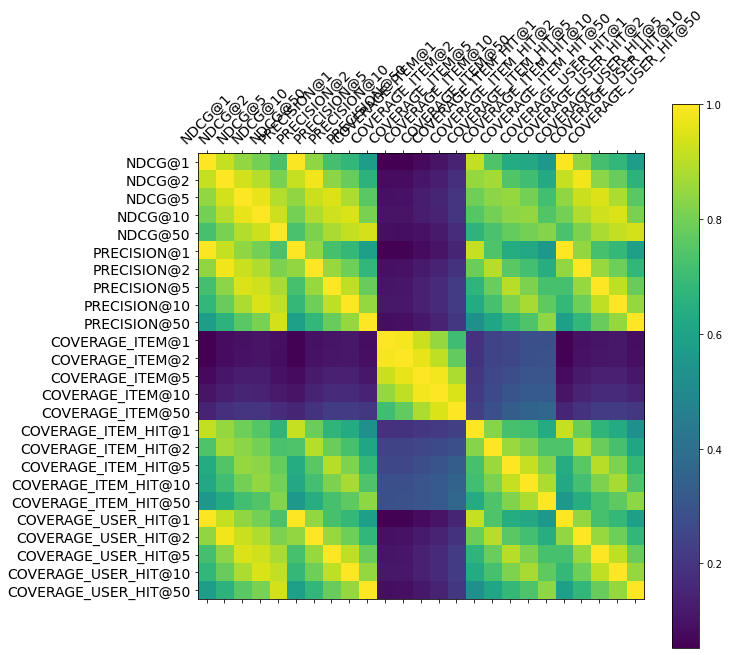

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
m = ax.matshow(corr_mat)
fig.colorbar(m)
xaxis = np.arange(len(corr_mat.columns))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(metric_name_list, fontsize=14, rotation=45)
ax.set_yticklabels(metric_name_list, fontsize=14)



In [116]:
corr_mat.columns

Index(['normalized_test_metric_NDCG_cut_1',
       'normalized_test_metric_NDCG_cut_2',
       'normalized_test_metric_NDCG_cut_5',
       'normalized_test_metric_NDCG_cut_10',
       'normalized_test_metric_NDCG_cut_50',
       'normalized_test_metric_PRECISION_cut_1',
       'normalized_test_metric_PRECISION_cut_2',
       'normalized_test_metric_PRECISION_cut_5',
       'normalized_test_metric_PRECISION_cut_10',
       'normalized_test_metric_PRECISION_cut_50',
       'normalized_test_metric_COVERAGE_ITEM_cut_1',
       'normalized_test_metric_COVERAGE_ITEM_cut_2',
       'normalized_test_metric_COVERAGE_ITEM_cut_5',
       'normalized_test_metric_COVERAGE_ITEM_cut_10',
       'normalized_test_metric_COVERAGE_ITEM_cut_50',
       'normalized_test_metric_COVERAGE_ITEM_HIT_cut_1',
       'normalized_test_metric_COVERAGE_ITEM_HIT_cut_2',
       'normalized_test_metric_COVERAGE_ITEM_HIT_cut_5',
       'normalized_test_metric_COVERAGE_ITEM_HIT_cut_10',
       'normalized_test_metric_COVE

## Table 1: show rank and normalized metrics for all algs, and a sample of datasets

In [117]:

# include cols for these datasets
display_datasets = [
    "Movielens1MReader",
    "Movielens100KReader",
    "Movielens20MReader"
    "AmazonMoviesTVReader",
    "AmazonLuxuryBeautyReader",
    "AmazonWineReader"
    "BookCrossingReader",
    "YahooMoviesReader",
    "CiaoDVDReader",
    "MovieTweetingsReader",
    "AnimeReader",
    "DatingReader",
    # "LastFMReader",  # many NaNs...
    "NetflixPrizeReader",
]

for metric_name in metric_list:

    display_metric = "normalized_" + metric_name
    display_rank = "rank_" + metric_name

    df_expt.loc[:, "display_text"] = df_expt.apply(lambda x: "{:.0f} ({:.2f})".format(x[display_rank], x[display_metric]), axis=1)

    table_1 = df_expt[df_expt["dataset_name"].isin(display_datasets)].pivot(index="alg_family", columns="dataset_name", values="display_text").reset_index()

    new_col_names = [c if ~c.endswith("Reader") else c[:-len("Reader")] for c in table_1.columns]
    new_col_names[0] = "Alg."
    table_1.columns = new_col_names
    
    # export table 1
    csv_name = f"./tables/table_1_{metric_name}.csv"
    tex_name = f"./tables/table_1_{metric_name}.tex"
    table_1.to_csv(csv_name, index=False)
    with open(tex_name, "w") as f:
        table_1.to_latex(f, index=False)
    print(f"wrote table to csv: {csv_name} and tex: {tex_name}")


wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_1.csv and tex: ./tables/table_1_test_metric_NDCG_cut_1.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_2.csv and tex: ./tables/table_1_test_metric_NDCG_cut_2.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_5.csv and tex: ./tables/table_1_test_metric_NDCG_cut_5.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_10.csv and tex: ./tables/table_1_test_metric_NDCG_cut_10.tex
wrote table to csv: ./tables/table_1_test_metric_NDCG_cut_50.csv and tex: ./tables/table_1_test_metric_NDCG_cut_50.tex
wrote table to csv: ./tables/table_1_test_metric_PRECISION_cut_1.csv and tex: ./tables/table_1_test_metric_PRECISION_cut_1.tex
wrote table to csv: ./tables/table_1_test_metric_PRECISION_cut_2.csv and tex: ./tables/table_1_test_metric_PRECISION_cut_2.tex
wrote table to csv: ./tables/table_1_test_metric_PRECISION_cut_5.csv and tex: ./tables/table_1_test_metric_PRECISION_cut_5.tex
wrote table to csv: ./tables/t

## Table 2: show max and min rank over all datasets for each metric.

In [118]:
# first show the number of algs with results for each dataset and each metric. (equal to max rank)
# only keep datasets which have at least 10 ranked algs for each metric
max_rank_table = df_expt.groupby("dataset_name")[["rank_" + m for m in metric_list]].max().reset_index()
drop_datasets = []
for c in max_rank_table.columns[1:]:
    if max_rank_table[c].min() < 10:
        # print(f"WARNING: column {c} has a dataset with only {max_rank_table[c].min()} algs")
        # print(max_rank_table[max_rank_table[c] < 10][["dataset_name", c]])
        # print(f"adding to drop_datasets...")
        drop_datasets.extend(max_rank_table[max_rank_table[c] < 10]["dataset_name"])

drop_datasets = set(drop_datasets)
print(f"datasets to drop: {drop_datasets}")

df_table_2 = df_expt.loc[~df_expt["dataset_name"].isin(drop_datasets), :]

print(f"remaining datasets: {len(df_table_2['dataset_name'].unique())}")
print(df_table_2['dataset_name'].unique())


datasets to drop: {'AmazonAllBeautyReader', 'AmazonMP3PlayersAccessoriesReader', 'AmazonBluesReader', 'AmazonInternationalReader', 'AmazonCollectiblesFineArtReader', 'AmazonAlternativeRockReader', 'AmazonAllElectronicsReader', 'FrappeReader', 'AmazonNewAgeReader', 'AmazonRockReader', 'AmazonPopReader', 'AmazonHardRockMetalReader', 'AmazonRapHipHopReader', 'AmazonGospelReader', 'GowallaReader', 'AmazonAppstoreforAndroidReader', 'LastFMReader', 'AmazonClothingShoesJewelryReader', 'AmazonHomeImprovementReader', 'AmazonCountryReader', 'YahooMusicReader', 'AmazonOfficeSchoolSuppliesReader', 'AmazonComputersReader', 'AmazonFolkReader', 'AmazonWineReader', 'AmazonRBReader', 'AmazonLatinMusicReader'}
remaining datasets: 58
['AmazonAmazonFashionReader' 'AmazonAmazonInstantVideoReader'
 'AmazonAppliancesReader' 'AmazonAppsforAndroidReader'
 'AmazonArtsCraftsSewingReader' 'AmazonAutomotiveReader'
 'AmazonBabyProductsReader' 'AmazonBabyReader' 'AmazonBeautyReader'
 'AmazonBuyaKindleReader' 'Amazon

In [119]:
df_table_2["alg_family"].unique()

array(['CoClustering', 'GlobalEffects', 'IALSRecommender', 'ItemKNNCF',
       'MatrixFactorization_AsySVD_Cython',
       'MatrixFactorization_BPR_Cython',
       'MatrixFactorization_FunkSVD_Cython', 'NMFRecommender',
       'P3alphaRecommender', 'PureSVDRecommender', 'RP3betaRecommender',
       'Random', 'SLIMElasticNetRecommender', 'SLIM_BPR_Cython', 'TopPop',
       'UserKNNCF', 'EASE_R_Recommender', 'SlopeOne'], dtype=object)

In [120]:
keep_alg_map = {
    "ItemKNNCF": {
        "name": "Item-KNN",
        "plt-kwargs": {"marker":"x", "color":"r", "linestyle":":"}
    },
    "UserKNNCF": {
        "name": "User-KNN",
        "plt-kwargs": {"marker":"+", "color":"b", "linestyle":"--"}
    },
    "P3alphaRecommender":{
        "name": "P3alpha",
        "plt-kwargs": {"marker":"^", "color":"g", "linestyle":"-."}
    },
    "MatrixFactorization_BPR_Cython":
    {
        "name": "MF-BPR",
        "plt-kwargs": {"marker":"v", "color":"gray", "linestyle":":"}
    },
    "IALSRecommender": {
        "name": "iALS",
        "plt-kwargs": {"marker":"D", "color":"c", "linestyle":"--"}
    },
    "SLIM_BPR_Cython": {
        "name": "SLIM-BPR",
        "plt-kwargs": {"marker":"s", "color":"purple", "linestyle":"-."}
    },
    "TopPop": {
        "name": "TopPop",
        "plt-kwargs": {"marker":"<", "color":"black", "linestyle":"-"}
    },
    "Random":{
        "name": "Random",
        "plt-kwargs": {"marker":">", "color":"black", "linestyle":"-"}
    },
}
keep_algs = list(keep_alg_map.keys())
alg_names = [v["name"] for v in keep_alg_map.values()]

# keep_algs = list(df_table_2["alg_family"].unique())

# get min and max rank for each alg and each metric over all algs.     each alg = col, row = metric
agg_dict = {
    "rank_" + metric: lambda x: "{:.0f}/{:.0f} ({:.1f})".format(min(x), max(x), np.mean(x)) for metric in metric_list
}
table_2_transpose = df_table_2[df_table_2["alg_family"].isin(keep_algs)].groupby("alg_family").agg(agg_dict).reset_index()

table_2 = table_2_transpose.transpose().copy()
new_cols = list(table_2.iloc[0,:])
table_2.columns = new_cols
table_2.drop(labels=("alg_family"), inplace=True)  # drop the first row, which is the alg name

# add the order ing
table_2.loc[:, "order"] = 0
for i, metric in enumerate(metric_list):
    table_2.at["rank_" + metric, "order"] = i

# now fix the metric names
new_index = []
for index_label in table_2.index:
    new_index.append(metric_name_map[index_label[len("rank_"):]])
table_2.index = new_index


In [121]:
# bookkeeping - order the rows
final_table_2 = table_2.sort_values("order").drop(columns="order")

# order the cols
final_table_2 = final_table_2.reindex(columns=keep_algs)

# bookeeping - rename the cols
new_col_names = ["\\rot{" + keep_alg_map[c]["name"] + "}" for c in final_table_2.columns]
final_table_2.columns = new_col_names


In [122]:
final_table_2.columns

Index(['\rot{Item-KNN}', '\rot{User-KNN}', '\rot{P3alpha}', '\rot{MF-BPR}',
       '\rot{iALS}', '\rot{SLIM-BPR}', '\rot{TopPop}', '\rot{Random}'],
      dtype='object')

In [123]:
# export table 2
csv_name = f"./tables/table_2.csv"
tex_name = f"./tables/table_2.tex"
final_table_2.to_csv(csv_name, index=True)
with open(tex_name, "w") as f:
    final_table_2.to_latex(f, index=True, escape=False)
print(f"wrote table to csv: {csv_name} and tex: {tex_name}")

wrote table to csv: ./tables/table_2.csv and tex: ./tables/table_2.tex


### Plot 1: plot change in metric across dataset for select algs
- each line in the series is an alg
- horizontal axis = datasets
- vertical axis = normalized metric

In [124]:
plot_alg_map = keep_alg_map
plot_algs = list(keep_alg_map.keys())
plot_alg_names = [v["name"] for v in keep_alg_map.values()]

plot_dataset_map = {
    'AmazonLuxuryBeautyReader': "Amz-Lux",
    'AmazonMiscellaneousReader': "Amz-Misc",
    # 'AmazonMusicalInstrumentsReader',
    # 'AmazonVideoGamesReader',
    'AnimeReader': "Anime",
    'BookCrossingReader': "BookCross",
    'CiaoDVDReader': "CiaoDVD",
    'EpinionsReader': "Epinions",
    'FilmTrustReader': "FilmTrust",
    # 'DatingReader',
    'Jester2Reader': "Jester",
    'MarketBiasAmazonReader': "MktBias-El",
    'MarketBiasModClothReader': "MktBias-Mod",
    'MovieTweetingsReader': "MvTweet",
    'Movielens100KReader': "Mvlns-100K",
    # 'Movielens10MReader',
    'Movielens1MReader': "Mvlns-1M",
    # 'Movielens20MReader',
    'MovielensHetrec2011Reader': "Mvlns-Hetrec",
    # 'NetflixPrizeReader',
    'RecipesReader': "Recipes.",
    'WikilensReader': "Wikilens",
    'YahooMoviesReader': "YahooMv.",
}
plot_datasets = list(plot_dataset_map.keys())
plot_dataset_names = list(plot_dataset_map.values())

In [126]:
plot_metric_map = {
    "normalized_" + "test_metric_PRECISION_cut_10":  "PREC@10",
    "normalized_" + "test_metric_COVERAGE_ITEM_HIT_cut_10":  "COV-ITEM-HIT@10",
    # "normalized_" + "test_metric_MAP_cut_10",
    "normalized_" + "test_metric_NDCG_cut_2": "NDCG@2",
    #  "normalized_" + "test_metric_NDCG_cut_2",
    # "normalized_" + "test_metric_RECALL_cut_10": "Norm. RECALL@10",
}
plot_metric_list = list(plot_metric_map.keys())


data = dict()

for metric_name in plot_metric_list:
    data[metric_name] = dict()
    for alg in plot_algs:
        data[metric_name][alg] = []
        for dataset in plot_datasets:
            vals = df_expt.loc[(df_expt["alg_family"] == alg) & (df_expt["dataset_name"] == dataset), metric_name].values
            if len(vals) != 1:
                print(f"there's an issue with {alg}-{dataset}-{metric_name}")
                print(vals)
                val = None
            else:
                val = vals[0]
            data[metric_name][alg].append(val)
    


# df_table_2

In [127]:
# make a plot
import matplotlib.pyplot as plt
import numpy as np

In [128]:
import matplotlib as mpl
mpl.__version__

'3.3.4'

In [129]:
import numpy as np

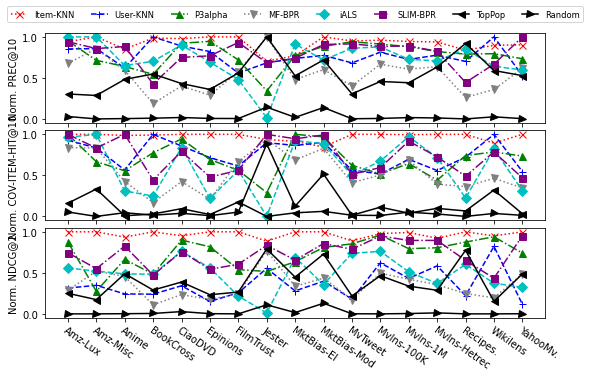

In [130]:
fig, ax = plt.subplots(len(plot_metric_list), 1, sharex=True, figsize=(8, 5))

for i, metric in enumerate(plot_metric_list):
    for alg in plot_algs:    
        ax[i].plot(data[metric][alg], label=plot_alg_map[alg]["name"], markersize=7, **plot_alg_map[alg]["plt-kwargs"])
    ax[i].set_ylabel(plot_metric_map[metric])

ax[i].set_xticks(np.arange(len(plot_dataset_names)))
ax[i].set_xticklabels(plot_dataset_names, rotation=-35, ha='left', rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(hspace=0.08)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 3.5), ncol=len(plot_algs), fontsize="small")
# plt.show()
plt.savefig("./fig/squiggly.pdf", bbox_inches='tight')